# Computing Galactic Orbits of Stars

We will use data from the [Gaia mission](https://www.cosmos.esa.int/web/gaia/data-release-2) to get sky positions, distances (parallaxes), proper motions, and radial velocities for a set of stars that are close to the Sun. From this, we use the positions and velocities as initial conditions to compute the orbits of these stars in the galaxy using the gala Python package. We will compare the orbits of high-mass [main sequence](https://www.space.com/22437-main-sequence-stars.html) (i.e. young) stars to the orbits of lower-mass main sequence stars to see if the orbits differ in any way.

## How to use this notebook

The code in this notebook is designed for entry level researchers and has been adapted to suit an undergraduate audience. Scientific and coding terms have been hyperlinked to sources that provide more detailed explanations. As you read through this notebook try to read the code to understand what instructions the computer is reading. You can annotate the code using `#` for brief notes or commas `""" your notes here"""` for more detailed notes. Where graphs have been plotted, try and intepret the results. Think about what other information you might be able to extract from the data, what would you like to see? Is there something you would do differently? Thinking in this way will help you to formulate your own research questions. Support your learning by using search engines. If you are unsure what a piece of code does, you can copy and paste the code directly into google to find more informative documentation.


## Installing Packages

Before we begin, you will need to install the gala and astroquery python packages. In a new Terminal window, input `pip install astro-gala astroquery` and press enter. During the installation process, your computer may ask you to install ‘Command Line Developer Tools’, if this occurs please install this program. If you do have to install the developer tools program, your installation of the packages may fail. If the installation fails, re-input `pip install astro-gala astroquery` into the same Terminal window as before and run. The packages should now be installed

In [1]:
"""Importing python packages """
# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


We'll start by querying the [Gaia science archive](http://gea.esac.esa.int/archive/) to download [astrometric](https://www.merriam-webster.com/dictionary/astrometry) and [kinematic](https://www.dictionary.com/browse/kinematic) data (parallax, proper motion, radial velocity) for a sample of stars near the Sun. We'll use data exclusively from [data release 2 (DR2)](https://www.cosmos.esa.int/web/gaia/data-release-2) from the *Gaia* mission. For the demonstration here, let's grab data for a random subset of 4096 stars within a distance of 100 [pc](https://en.wikipedia.org/wiki/Parsec) from the Sun that have high [signal-to-noise](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) astrometric measurements.

To perform the query and to retrieve the data, we'll use the *Gaia* module in the [astroquery](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, `astroquery.gaia`. We don't need all of the columns that are available in DR2, so we'll limit our query to request the sky position (`ra`, `dec`), parallax, [proper motion](https://en.wikipedia.org/wiki/Proper_motion) components (`pmra`, `pmdec`), radial velocity, and magnitudes (`phot_*_mean_mag`). More information about the available columns is in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html). 

To select stars that have high signal-to-noise parallaxes, we'll use the filter ``parallax_over_error > 10`` to select stars that have small fractional uncertainties. We'll also use the filter ``radial_velocity IS NOT null`` to only select stars that have measured radial velocities.

In [2]:
"""Importing Gaia data from the second release using astroquery"""

query_text = '''SELECT TOP 4096 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

Note that you may receive a number of warnings (output lines that begin with WARNING:) from the astropy.io.votable package — these are expected, and it's OK to ignore these warnings.

In [3]:
"""This cell only needs to be run once. After first successful run please comment out"""
#job = Gaia.launch_job(query_text)
#gaia_data = job.get_results()
#gaia_data.write('gaia_data.fits')

'This cell only needs to be run once. After first successful run please comment out'

In [4]:
"""Reading the data into a table"""

gaia_data = QTable.read('gaia_data.fits')

In [5]:
#exporting gaia_data as text file
np.savetxt('gaia_data', gaia_data)


The `data` object is now an Astropy `Table` called `gaia_data` that contains `Gaia` data for 4096 random stars within 100 pc (or with a parallax > 10 mas) of the Sun, as we requested. Let's look at the first four rows of the table:

In [6]:
"""Printing the first 4 rows of the data table with units specified in the second row"""
gaia_data[:4]

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float64,float32,float32,float32
256.8370985186671,46.5081010273448,10.770964834345387,-19.76657104695835,55.92605676622464,-17.673072044811907,12.956912994384766,14.192928314208984,11.859498023986816
129.45826809010867,-6.806694022293258,41.081670013380716,-297.34595349374183,43.83424795415093,35.53814452290586,6.576352119445801,6.931065082550049,6.111272811889648
2.317856723637118,9.00699655780345,17.824765284426462,-171.8278607514459,-1083.8740928197751,-148.91780163518774,13.119074821472168,13.968703269958496,12.223302841186523
330.41287472805976,51.88897801553169,13.0756133009657,-85.30745872006916,-34.23366534215265,-28.726469345049587,12.101919174194336,13.05264949798584,11.149785995483398


## Using `astropy.coordinates` to represent and transform stellar positions and velocities

Let's double check that the farthest star is still within 100 pc, as we expect from the parallax selection we did in the query above. To do this, we'll create an Astropy `Distance` object using the parallax (*Note: this inverts the parallax to compute the distance! This is only a good approximation when the parallax signal to noise is large, as we ensured in the query above with `parallax_over_error > 10`*):

In [7]:
"""Extracting the minimum and maximum distances from the parallax values within the selected data"""

dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

(<Distance 8.79909291 pc>, <Distance 99.99985292 pc>)

It looks like the closest star in our sample is about 9 pc away, and the farthest is almost 100 pc, as we expected.

The data recorded by Gaia is centered about the centre of the sun. The coordinates of this data set need to be transformed so that they are centered about the centre of the Milky Way. For this, we will use [Galactocentric](https://en.wikipedia.org/wiki/Galactic_coordinate_system) [Cartesian coordinates](https://en.wikipedia.org/wiki/Cartesian_coordinate_system).

We can change the position and velocity coordinates using the [Astropy coordinates](http://docs.astropy.org/en/latest/coordinates/index.html) package. To do this we need to create a `Skycord` object that contains our Gaia data.

In [8]:
"""Inputting data into a Skycord object ready for coordinate transformation"""

c = coord.SkyCoord(ra=gaia_data['ra'], 
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'], 
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

Note: In the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html), the Gaia column `pmra` contains the [cos(dec)](https://community.dur.ac.uk/physics.astrolab/one_lab/pm_coord.html) term. In Astropy coordinates, the name of this component is `pm_ra_cosdec`.

Let's again look at the first four coordinates in the `SkyCoord` object:

In [9]:
"""Printing the first four rows of Skycord object to check values match those from gaia_data table"""

c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(256.83709852, 46.50810103, 92.84219338),
     (129.45826809, -6.80669402, 24.3417563 ),
     (  2.31785672,  9.00699656, 56.1017205 ),
     (330.41287473, 51.88897802, 76.47824825)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( -19.76657105,    55.92605677,  -17.67307204),
     (-297.34595349,    43.83424795,   35.53814452),
     (-171.82786075, -1083.87409282, -148.91780164),
     ( -85.30745872,   -34.23366534,  -28.72646935)]>

Now that we have a `SkyCoord` object with the Gaia data, we can transform to other coordinate systems. For example, we can transform to the [`Galactic`](https://docs.astropy.org/en/latest/api/astropy.coordinates.Galactic.html#astropy.coordinates.Galactic) coordinate system (centered on the solar system [barycenter](https://spaceplace.nasa.gov/barycenter/en/) but with the zero latitude approximately aligned with the Galactic plane) using the `.galactic` attribute (this works for any of the [built-in Astropy coordinate frames](http://docs.astropy.org/en/latest/coordinates/index.html#reference-api)).

In [10]:
"""Printing the first four rows of Skycord object values which have been transformed to the galactic coordinate system"""

c.galactic[:4]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [( 72.32926334,  36.8367097 , 92.84219338),
     (232.07542475,  19.9763116 , 24.3417563 ),
     (105.68646983, -52.44715126, 56.1017205 ),
     ( 98.28701089,  -2.66800849, 76.47824825)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(  55.13035551,   21.88801174,  -17.67307204),
     (-195.30630898, -228.4545973 ,   35.53814452),
     (-455.13470935, -998.57912013, -148.91780164),
     ( -88.74713695,   23.94268239,  -28.72646935)]>

The `Galactic` frame is still centered on the solar system barycenter, whereas we want to compute the positions and velocities of our sample of stars in a Galactocentric frame, centered on the center of the Milky Way. To do this transformation, Astropy provides the `Galactocentric` frame class, which allows us to use our own conventions for, e.g., the distance from the sun to the Galactic center (`galcen_distance`) or the height of the Sun over the Galactic midplane (`z_sun`). Let's look at the default values for the solar position and velocity:

In [11]:
"""Printing the Galactocentric default values for solar position and velocity"""

coord.Galactocentric()

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg)>

We'll instead use a distance of 8.1 kpc — more consistent with the [recent results from the GRAVITY collaboration](https://arxiv.org/abs/1807.09409) — and a solar height of 0 pc. We'll use the default solar velocity (see output above). We can transform our data to this frame using the `transform_to()` method by specifying the `Galactocentric` frame with our adopted values:

In [12]:
"""Transforming coordinate system of Skycoord object values from the Galactic frame to the
Galactocentric frame with a custom galcen_distance value (sun to galactic centre distance) of 8.1 kpc"""

galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc, 
                                             galcen_distance=8.1*u.kpc))

The galcen object now contains the data for our sample, but in the Galactocentric frame:

In [13]:
"""Printing the first four rows of the Skycord object values which have been transformed to the galactocentric coordinate system"""
galcen[:4]

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.1 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=0.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8077.44468803,  70.79989896,  55.66242071),
     (-8114.06090109, -18.04601124,   8.31586669),
     (-8109.24493623,  32.92015736, -44.47693151),
     (-8111.0109288 ,  75.59768012,  -3.55986822)]
 (v_x, v_y, v_z) in km / s
    [(-18.06556759, 220.62501167,   4.36424163),
     (-32.74107553, 212.64094753,  -5.38474972),
     (209.09926667, -25.11804786, -36.55277769),
     ( 47.01632893, 208.88147077,  17.25803683)]>

## Plotting the data

Now the Gaia data has been transformed into the Galactocentric cartesian coordinate system, we can explore the data by using various plotting techniques. Visualising the data in different ways enables us to meaningfully extract different aspects of the information contained within the data.

We can access the positions of the stars using the .x, .y, and .z attributes.

Text(0, 0.5, 'number of stars')

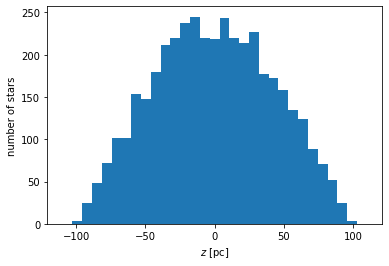

In [14]:
"""A histogram plot of the distribution of stars about the galactic plane (z direction)"""

plt.hist(galcen.z.value, bins=np.linspace(-110, 110, 32))
plt.xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit));
plt.ylabel('number of stars')

What information can you conclude from the above histogram plot?

Similarly, for the velocity components, we can use `.v_x`, `.v_y`, and `.v_z`. For example, to create a classic "UV" plane velocity plot:

Text(0, 0.5, '$v_y$ [$\\mathrm{km\\,s^{-1}}$]')

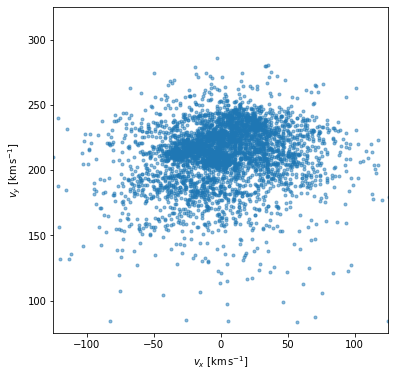

In [15]:
"""A scatter graph of x and y velocity components of the selected stars"""

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(galcen.v_x.value, galcen.v_y.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_y$ [{0:latex_inline}]'.format(u.km/u.s))


What information can you conclude from the above scatter plot?

Along with astrometric and radial velocity data, `Gaia` also provides [photometric data](https://www.cosmos.esa.int/web/gaia/iow_20180316) for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia [Color-Magnitude Diagram (CMD)](https://www.britannica.com/science/colour-magnitude-diagram) using the $G_{\rm BP}-G_{\rm RP}$ color and the absolute $G$-band magnitude $M_G$. We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus:

In [16]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod #calculating the absolute magnitude of G-band
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag'] #calculating G_BP-G_RP colour

Text(0, 0.5, '$M_G$')

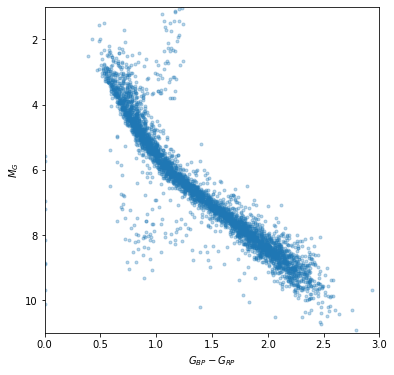

In [17]:
"""Generating a colour-magnitude diagram"""

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP, M_G, 
        marker='.', linestyle='none', alpha=0.3)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In the above, there is a wide range of main sequence star masses which have a range of lifetimes. The most massive stars were likely born in the thin disk and their orbits therefore likely have smaller vertical amplitudes than the typical old main sequence star. To compare, we'll create two sub-selections of the Gaia CMD to select massive and low-mass main sequence stars from the CMD for comparison. You may see two ``RuntimeWarning``(s) from running the next cell — these are expected and it's safe to ignore them.

In [18]:
np.seterr(invalid="ignore")
#conditions to select high mass stars
hi_mass_mask = ((BP_RP > 0.5*u.mag) & (BP_RP < 0.7*u.mag) & 
                (M_G > 2*u.mag) & (M_G < 3.75*u.mag) & 
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

#conditions to select low mass stars
lo_mass_mask = ((BP_RP > 2*u.mag) & (BP_RP < 2.4*u.mag) & 
                (M_G > 8.2*u.mag) & (M_G < 9.7*u.mag) &
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

Let's also define default colors to use when visualizing the high- and low-mass stars:

In [19]:
hi_mass_color = 'tab:red'
lo_mass_color = 'tab:purple'

Let's now visualize these two CMD selections:

Text(0, 0.5, '$M_G$')

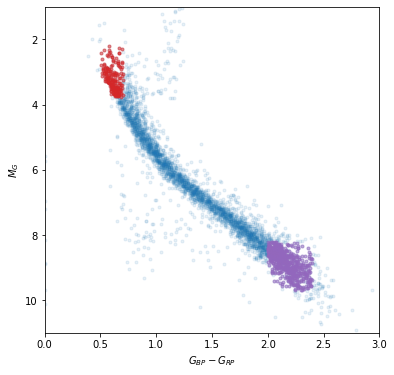

In [20]:
"""Colour-magnitude diagram where high mass stars are red and low mass stars are purple"""

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP, M_G, 
        marker='.', linestyle='none', alpha=0.1)

for mask, color in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color]):
    ax.plot(BP_RP[mask], M_G[mask], 
            marker='.', linestyle='none', 
            alpha=0.5, color=color)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

Thus far, we've used the color-magnitude diagram (using parallaxes and photometry from Gaia to compute absolute magnitudes) to select samples of high- and low-mass stars based on their colors.

In what follows, we'll compute Galactic orbits for stars in the high- and low-mass star selections above and compare.

## Using `gala` to numerically integrate Galactic stellar orbits

To calculate the stellar orbits via numerical integration we first need to model the gravitational potential. The gravitational potential models are defined by specifying parameters such as mass, scale radii, or shape parameters. Once defined, they can be used in combination with numerical integrators provided in `gala` to compute orbits. `gala` comes with a pre-defined, multi-component, but [simple model for the Milky Way](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) that can be used for orbit integrations. Let's create an instance of the `MilkyWayPotential` model and integrate orbits for the high- and low-mass main sequence stars selected above:

In [21]:
"""Defining the mass model"""

milky_way = gp.MilkyWayPotential() #gala potential components
milky_way

<CompositePotential disk,bulge,nucleus,halo>

This model has mass components for the Galactic disk, bulge, nucleus, and halo, and the parameters were defined by fitting measurements of the Milky Way enclosed mass at various radii. See [this document](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) for more details. The parameters of the `MilkyWayPotential` can be changed by passing in a dictionary of parameter values to argument names set by the component names. For example, to change the disk mass to make it slightly more massive (the choice `8e10` is arbitrary!):

In [22]:
"""Changing galactic disk mass in MilkyWayPotential"""

different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
different_disk_potential

<CompositePotential disk,bulge,nucleus,halo>

To integrate orbits, we have to combine the mass model with a reference frame into a `Hamiltonian` object. If no reference frame is passed in, it's assumed that we are in a static [inertial frame](https://en.wikipedia.org/wiki/Inertial_frame_of_reference) moving with the center of the mass model:

In [23]:
"""Combining mass model with default reference frame into a Hamiltonian object"""

H = gp.Hamiltonian(milky_way) #using default static inertial frame moving with the center of the mass model

Now that we have the mass model, we can integrate orbits. Let's now define initial conditions for subsets of the high- and low-mass star selections we did above. Initial conditions in `gala` are specified by creating `PhaseSpacePosition` objects. We can create these objects directly from a `Galactocentric` object, like we have defined above from transforming the Gaia data — we first have to extract the data with a Cartesian representation. We can do this by calling `galcen.cartesian`:

In [24]:
"""Extracting the number of high-mass and low-mass stars present in data"""

w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian) #no. high-mass stars
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian) #no. of low-mass stars
w0_hi.shape, w0_lo.shape

((185,), (577,))

From the above, we can see that we have 185 high-mass star and 577 low-mass stars in our selections. To integrate orbits, we call the .integrate_orbit() method on the Hamiltonian object we defined above, and pass in initial conditions. We also have to specify the timestep for integration, and how long we want to integrate for. We can do this by either specifying the amount of time to integrate for, or by specifying the number of timesteps. Let's specify a timestep of 1 Myr and a time of 500 Myr (approximately two revolutions around the Galaxy for a Sun-like orbit):

In [25]:
"""Setting integration initial condtions, limits and time steps for high and low mass stars"""

orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr,             #high-mass star conditions
                              t1=0*u.Myr, t2=500*u.Myr)  

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr,             #low-mass star conditions 
                              t1=0*u.Myr, t2=500*u.Myr)

With the orbit objects in hand, we can continue our comparison of the orbits of high-mass and low-mass main sequence stars in the solar neighborhood. Let's start by plotting a few orbits. The .plot() convenience function provides a quick way to visualize orbits in three Cartesian projections. For example, let's plot the first orbit in each subsample on the same figure:

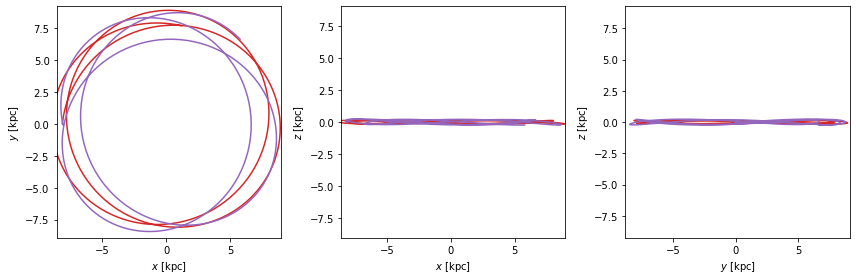

In [26]:
fig = orbits_hi[:, 0].plot(color=hi_mass_color)   #high-mass stars in red
_ = orbits_lo[:, 0].plot(axes=fig.axes, color=lo_mass_color) #low-mass stars in purple

Note in the above figure that the orbits are almost constrained to the x-y plane: the excursions are much larger in the x and y directions as compared to the z direction.

The default plots show all Cartesian projections. This can be customized to, for example, only show specified components (including velocity components):

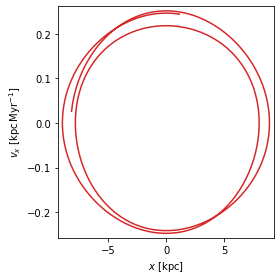

In [27]:
fig = orbits_hi[:, 0].plot(['x', 'v_x'], 
                           auto_aspect=False, 
                           color=hi_mass_color)

The representation can also be changed, for example, to a cylindrical representation:

(-0.3, 0.3)

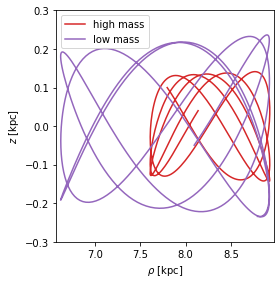

In [28]:
fig = orbits_hi[:, 0].cylindrical.plot(['rho', 'z'], 
                                       color=hi_mass_color,
                                       label='high mass')
_ = orbits_lo[:, 0].cylindrical.plot(['rho', 'z'], color=lo_mass_color,
                                     axes=fig.axes,
                                     label='low mass')

fig.axes[0].legend(loc='upper left')
fig.axes[0].set_ylim(-0.3, 0.3)

Already in the above plot we can see that the high-mass star has an orbit with smaller eccentricity (smaller radial variations) and smaller vertical oscillations as compared to the low-mass star. Below, we'll quantify this and look at the vertical excursions of all of the high- and low-mass stars, respectively.

Let's now compare the vertical amplitudes of the orbits in each of our sub-selections! We can compute the (approximate) maximum vertical height of each orbit using the convenience method `.zmax()` (you can see a list of all convenience methods on the `Orbit` object [in the Gala documentation here](http://gala.adrian.pw/en/latest/api/gala.dynamics.Orbit.html#gala.dynamics.Orbit)):

In [29]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

Let's make histograms of the maximum $z$ heights for these two samples:

Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

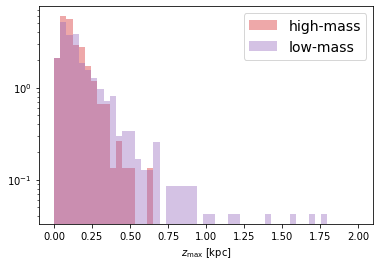

In [30]:
bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

The distribution of $z$-heights for the low-mass (i.e. typically older) stars is more extended.

In this tutorial, we've used `astroquery` to query the Gaia science archive to retrieve kinematic and photometric data for a small sample of stars with well-measured parallaxes from Gaia DR2. We used the colors and absolute magnitudes of these stars to select subsamples of high- and low-mass stars, which, on average, will provide us with subsamples of stars that are younger and older, respectively. We then constructed a model for the gravitational field of the Milky Way and numerically integrated the orbits of all stars in each of the two subsamples. Finally, we used the orbits to compute the maximum height that each star reaches above the Galactic midplane and showed that the younger (higher-mass) stars tend to have smaller excursions from the Galactic plane, consistent with the idea that stars are either born in a "thinner" disk and dynamically "heated," or that older stars formed with a larger vertical scale-height.

The work contained within this document was originally written by
Adrian Price-Whelan, Stephanie T. Douglas and has been adapted by Emma Osborne